In [1]:
import gym
import gym_anytrading

from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions 
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL
import matplotlib.pyplot as plt
from keras import applications
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, Input, Concatenate, Conv2D, BatchNormalization, Permute
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.agents.ddpg import DDPGAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.random import OrnsteinUhlenbeckProcess
from rl.callbacks import FileLogger, ModelIntervalCheckpoint, TrainIntervalLogger
from rl.processors import WhiteningNormalizerProcessor

from sklearn import preprocessing
import random
import warnings
warnings.filterwarnings('ignore')

import json
import numpy as np
from evaluator import Evaluator

Using TensorFlow backend.
d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\py

## Utility

In [2]:
class DDPGProcessor(Processor):
    def process_action(self, actions):
        exp = np.exp(actions)
        scaled_action = exp / np.sum(exp)
        return np.random.choice([0,1], p=scaled_action)

class CustomDDPGAgent(DDPGAgent):
    def select_action(self, state):
        eps = 0.1
        if self.training and np.random.uniform() < eps:
            return [0.5, 0.5]
        else:
            return super(CustomDDPGAgent, self).select_action(state)
        


### Forex-v0 default

In [3]:
window_size=24
def env_creator():
    return gym.make('forex-v0', frame_bound=(50, 5000), window_size=window_size)

env = env_creator()
obs = env.reset()
env_shape=obs.shape
nb_actions = env.action_space.n

def simple_critic_actor():
    nb_actions = 2
    # Next, we build a very simple model.
    actor = Sequential()
    actor.add(Flatten(input_shape=(1,) + env_shape))
    actor.add(Dense(128))
    actor.add(Activation('relu'))
    actor.add(Dense(64))
    actor.add(Activation('relu'))
    actor.add(Dense(nb_actions))
    actor.add(Activation('softmax'))
    # print(actor.summary())

    action_input = Input(shape=(nb_actions,), name='action_input')
    a1 = Dense(64, activation='linear')(action_input)
    observation_input = Input(shape=(1,) + env_shape, name='observation_input')
    flattened_observation = Flatten()(observation_input)
    x = Concatenate()([a1, flattened_observation])
    x = Dense(256)(x)
    x = Activation('relu')(x)
    x = Dense(128)(x)
    x = Activation('relu')(x)
    x = Dense(1)(x)
    x = Activation('linear')(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return actor, critic, action_input

#criticModel()[0].summary()
def agent_creator():
    actor, critic, action_input = simple_critic_actor()
    memory = SequentialMemory(limit=256, window_length=1)
    processor = DDPGProcessor()
    random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=0.05, mu=0.02, sigma=0.03)
    agent = DDPGAgent(nb_actions=2, actor=actor, critic=critic, critic_action_input=action_input,
                      memory=memory, nb_steps_warmup_critic=128, nb_steps_warmup_actor=128, batch_size=64, train_interval=32,
                      random_process=random_process,processor=processor, gamma=.5, target_model_update=0.001)
    agent.compile(Adam(lr=.001, clipnorm=1.), metrics=['mae'])
    return agent

Instructions for updating:
Colocations handled automatically by placer.
starting train 1
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
107/989 [==>...........................] - ETA: 1s - reward: 1.7981 - cumulative_reward: 66.8692         WARNING:tensorflow:From d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\python\ops\math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
989/989 [==============================] - 4s 4ms/step - reward: -0.5360 - cumulative_reward: -24.8696
train 1 completed. took 5.285 seconds, total_reward: -530.5000000000841 total_profit: 0.6972455070229316
min reward: -122.40000000000029, max reward: 203.40000000000026, mean_reward: -0.10719337239848134


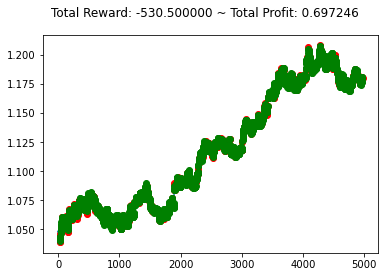

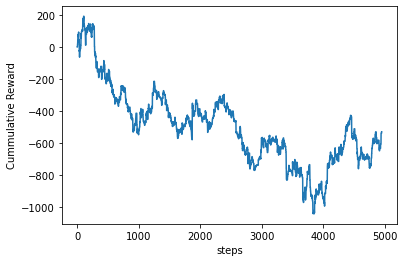

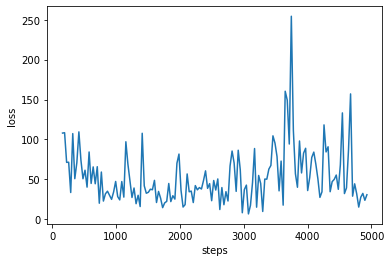

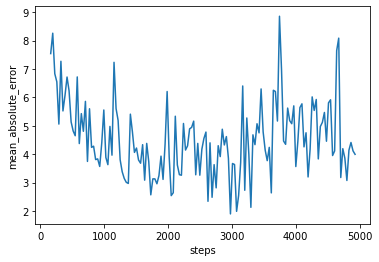

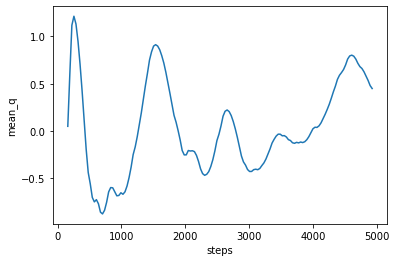

starting train 2
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 5s 5ms/step - reward: 0.0054 - cumulative_reward: -17.6570
train 2 completed. took 12.487 seconds, total_reward: 5.299999999895171 total_profit: 0.7220295761461366
min reward: -122.70000000000225, max reward: 145.29999999999933, mean_reward: 0.0010709234188513177


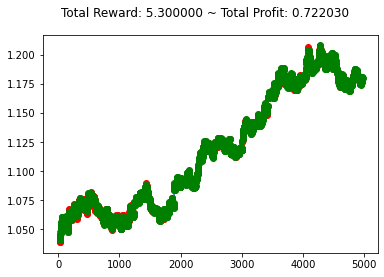

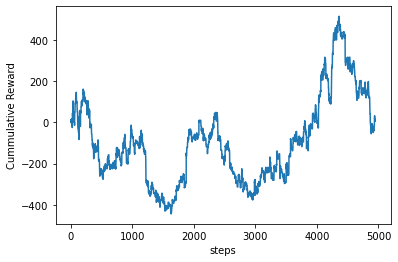

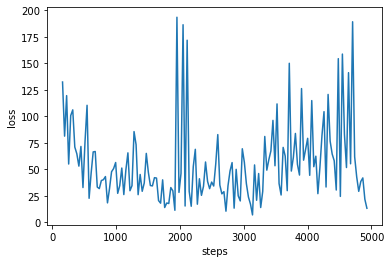

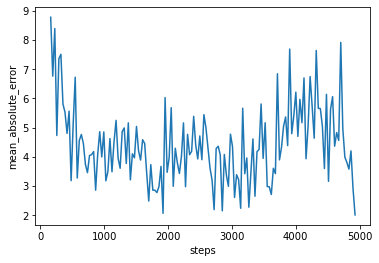

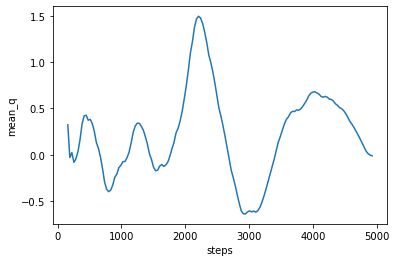

starting train 3
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 5s 5ms/step - reward: -28.8893 - cumulative_reward: -611.6556
train 3 completed. took 20.686 seconds, total_reward: -781.2000000000123 total_profit: 0.6960903322352697
min reward: -195.19999999999982, max reward: 78.00000000000028, mean_reward: -0.15785007072136034


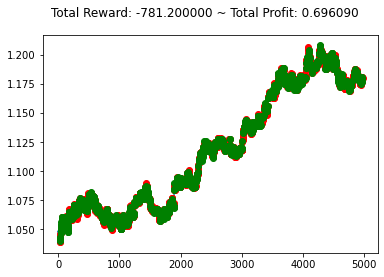

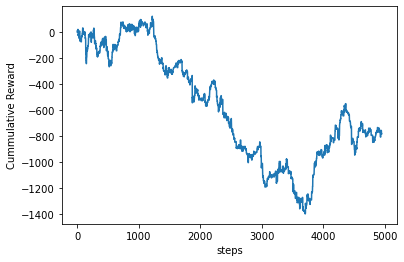

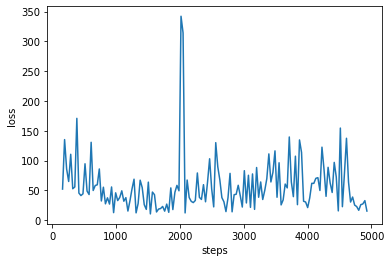

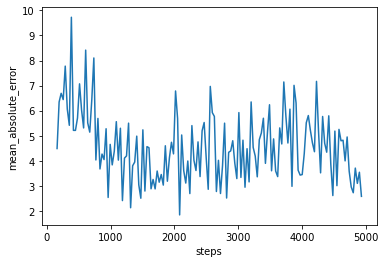

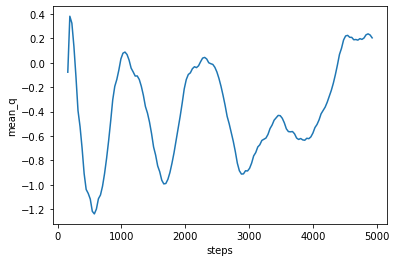

starting train 4
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 6s 6ms/step - reward: -14.1047 - cumulative_reward: -637.0805
train 4 completed. took 30.468 seconds, total_reward: -895.5000000000011 total_profit: 0.6967604397042072
min reward: -185.10000000000025, max reward: 119.89999999999945, mean_reward: -0.1809456455849669


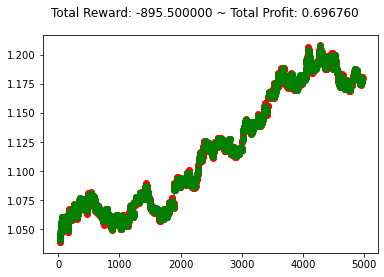

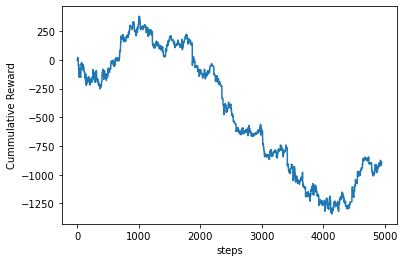

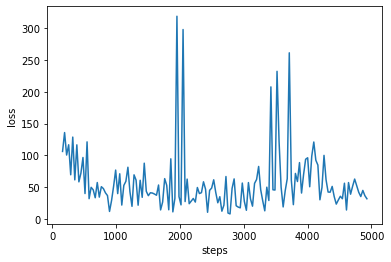

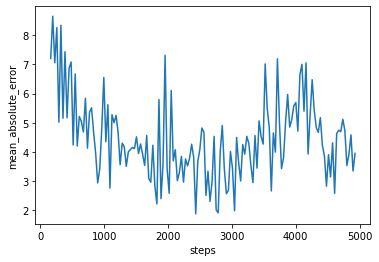

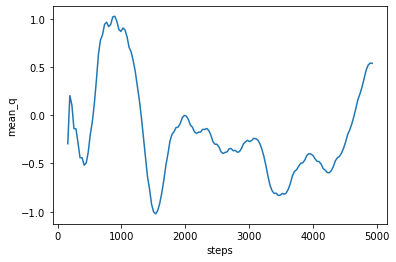

starting train 5
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 7s 7ms/step - reward: -21.4974 - cumulative_reward: 696.7132
train 5 completed. took 42.285 seconds, total_reward: 695.4000000000082 total_profit: 0.7376768782112316
min reward: -122.59999999999937, max reward: 155.40000000000109, mean_reward: 0.14051323499697074


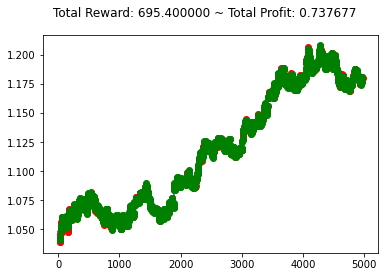

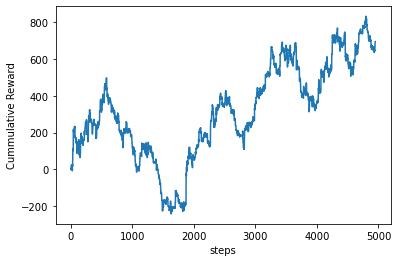

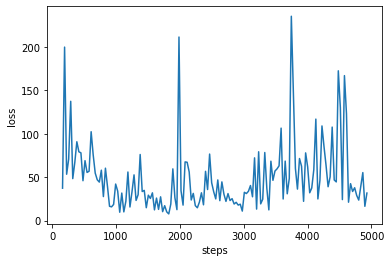

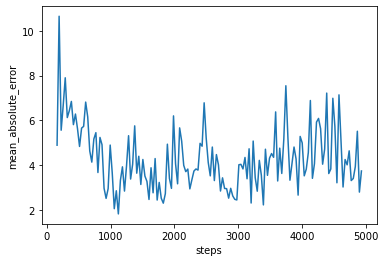

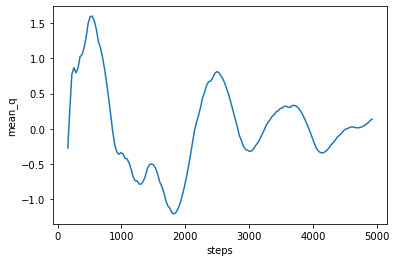

starting train 6
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 7s 8ms/step - reward: 22.4079 - cumulative_reward: 51.9003
train 6 completed. took 54.624 seconds, total_reward: 205.80000000002082 total_profit: 0.7265232019829656
min reward: -121.70000000000014, max reward: 154.50000000000185, mean_reward: 0.04158415841584579


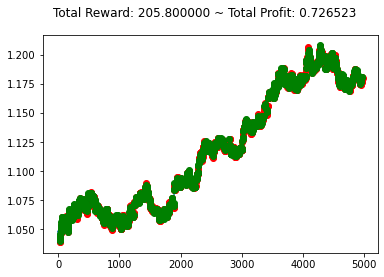

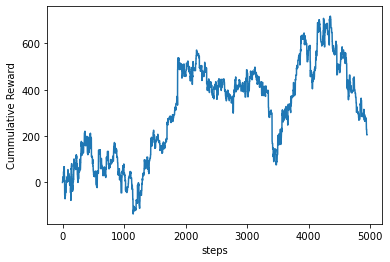

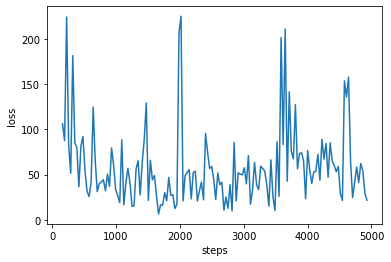

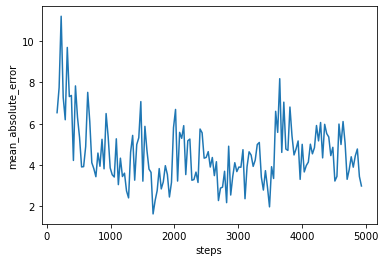

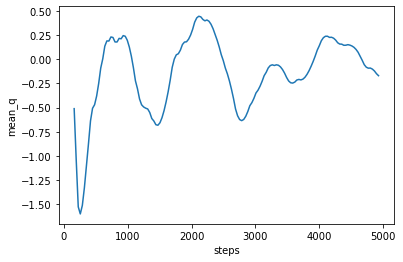

starting train 7
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 7s 8ms/step - reward: 45.2526 - cumulative_reward: 542.8306
train 7 completed. took 67.825 seconds, total_reward: 1041.900000000015 total_profit: 0.7521904071344434
min reward: -104.69999999999979, max reward: 181.00000000000006, mean_reward: 0.21052737926854215


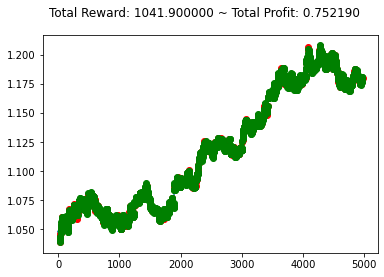

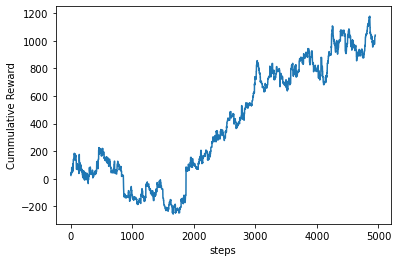

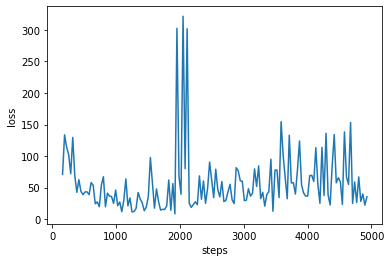

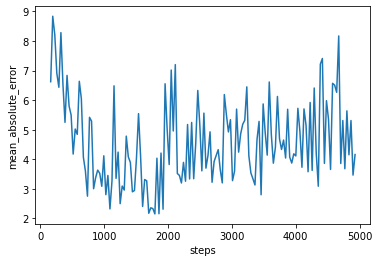

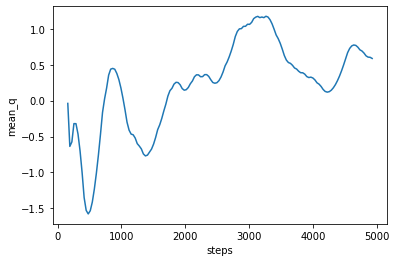

starting train 8
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 10s 11ms/step - reward: 19.4794 - cumulative_reward: -304.6890
train 8 completed. took 85.362 seconds, total_reward: -119.39999999996515 total_profit: 0.7171787944783472
min reward: -130.90000000000046, max reward: 168.70000000000164, mean_reward: -0.024126086077988513


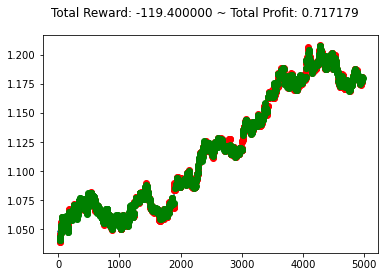

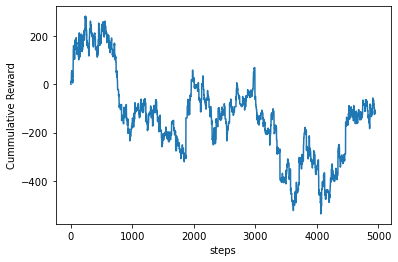

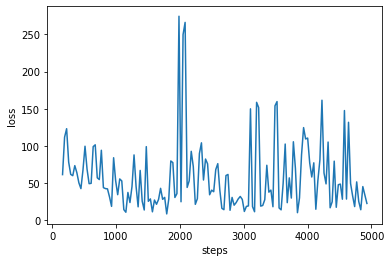

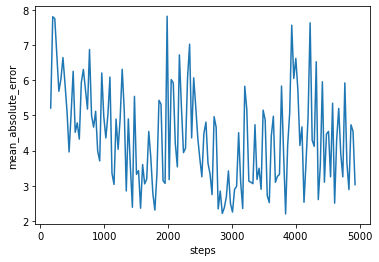

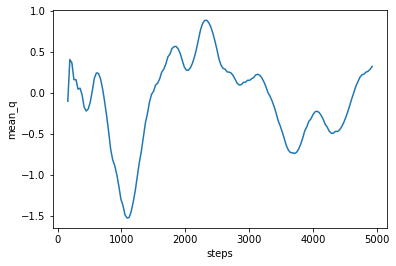

starting train 9
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 9s 9ms/step - reward: -23.7983 - cumulative_reward: -28.5272
train 9 completed. took 101.876 seconds, total_reward: -97.29999999994754 total_profit: 0.7239629799337493
min reward: -129.39999999999952, max reward: 159.59999999999974, mean_reward: -0.019660537482309063


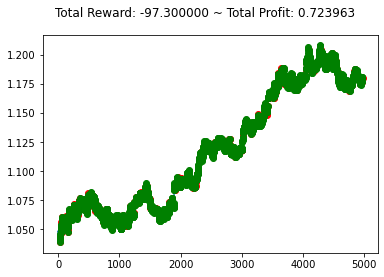

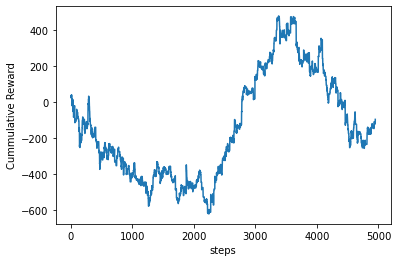

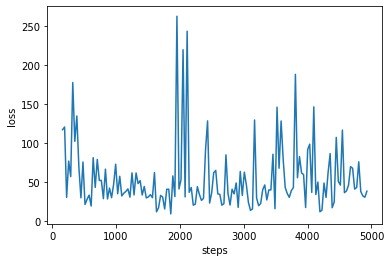

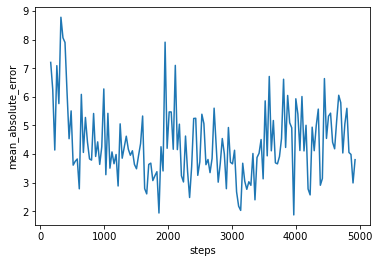

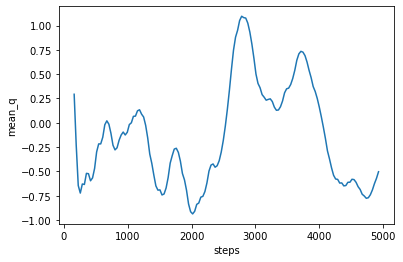

starting train 10
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 10s 10ms/step - reward: -24.2793 - cumulative_reward: -766.4872
train 10 completed. took 121.063 seconds, total_reward: -1266.30000000006 total_profit: 0.6778041576974938
min reward: -168.70000000000164, max reward: 111.0000000000011, mean_reward: -0.25586987270156797


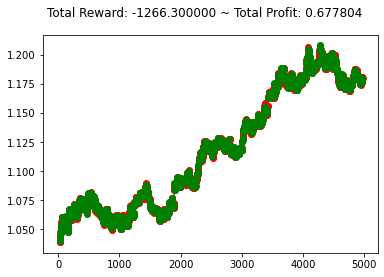

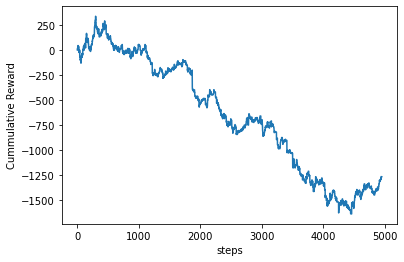

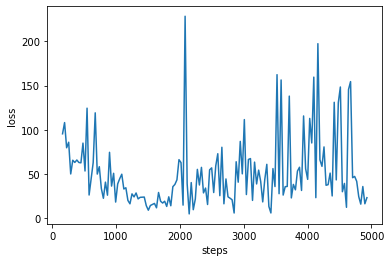

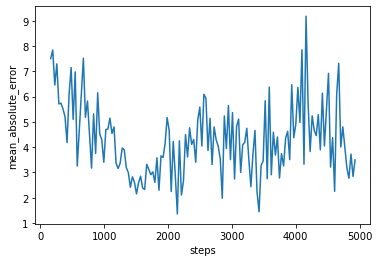

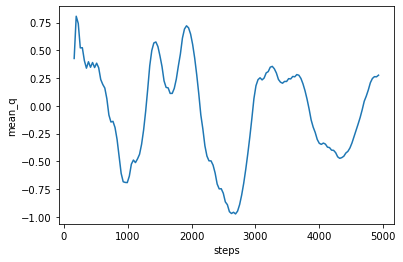

In [4]:
from evaluator import Evaluator

e = Evaluator(agent_creator, env_creator, name="ddpg")
e.train(repeat=10)


average of total_reward across trainings: [-174.18]


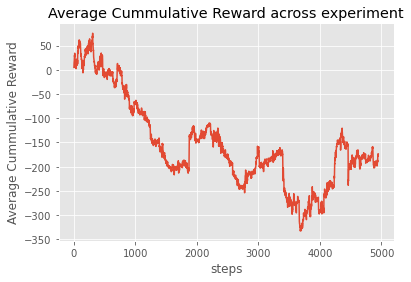

Testing for 1 episodes ...
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
176/199 [=========================>....] - ETA: 0s - reward: -32.2857 - cumulative_reward: 147.4887Episode 1: reward: 400.800, steps: 999
test completed. total_reward: 400.8000000000214 total_profit: 0.9691864698651655
min reward: -64.5999999999991, max reward: 60.40000000000045, mean_reward: 0.4012012012012226


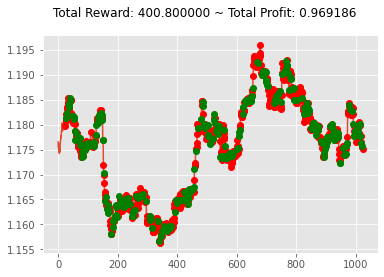

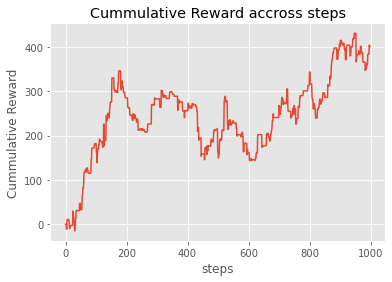

In [5]:
e.process_train_result()
e.test(gym.make('forex-v0', frame_bound=(5000, 6000), window_size=window_size))

### Forex-v0 full feature

In [6]:
from custom_env import ForexV0FullFeature
def env_creator():
    return ForexV0FullFeature(df=FOREX_EURUSD_1H_ASK, frame_bound=(50, 5000), window_size=window_size)
env = env_creator()
obs = env.reset()
env_shape=obs.shape
print(env_shape)
nb_actions = env.action_space.n

def simple_critic_actor():
    nb_actions = 2
    # Next, we build a very simple model.
    actor = Sequential()
    actor.add(Flatten(input_shape=(1,) + env_shape))
    actor.add(Dense(128))
    actor.add(Activation('relu'))
    actor.add(Dense(64))
    actor.add(Activation('relu'))
    actor.add(Dense(nb_actions))
    actor.add(Activation('softmax'))
    # print(actor.summary())

    action_input = Input(shape=(nb_actions,), name='action_input')
    a1 = Dense(64, activation='linear')(action_input)
    observation_input = Input(shape=(1,) + env_shape, name='observation_input')
    flattened_observation = Flatten()(observation_input)
    x = Concatenate()([a1, flattened_observation])
    x = Dense(256)(x)
    x = Activation('relu')(x)
    x = Dense(128)(x)
    x = Activation('relu')(x)
    x = Dense(1)(x)
    x = Activation('linear')(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return actor, critic, action_input

#criticModel()[0].summary()
def agent_creator():
    actor, critic, action_input = simple_critic_actor()
    memory = SequentialMemory(limit=256, window_length=1)
    processor = DDPGProcessor()
    random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=0.05, mu=0.02, sigma=0.03)
    agent = DDPGAgent(nb_actions=2, actor=actor, critic=critic, critic_action_input=action_input,
                      memory=memory, nb_steps_warmup_critic=128, nb_steps_warmup_actor=128, batch_size=64, train_interval=32,
                      random_process=random_process,processor=processor, gamma=.5, target_model_update=0.001)
    agent.compile(Adam(lr=.001, clipnorm=1.), metrics=['mae'])
    return agent

(24, 15)


starting train 1
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 12s 12ms/step - reward: 25.1961 - cumulative_reward: -899.2646
train 1 completed. took 18.989 seconds, total_reward: -993.6999999999973 total_profit: 0.6862221788172305
min reward: -143.90000000000347, max reward: 138.60000000000207, mean_reward: -0.20078803798747166


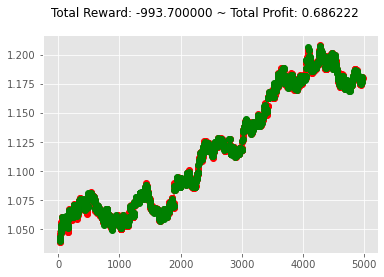

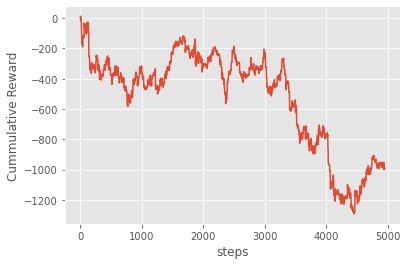

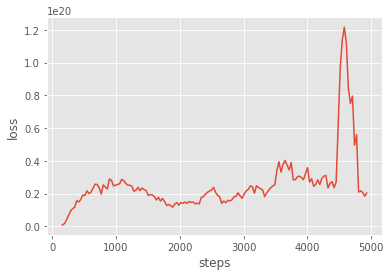

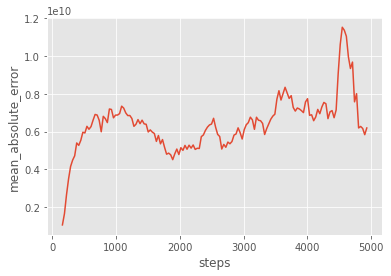

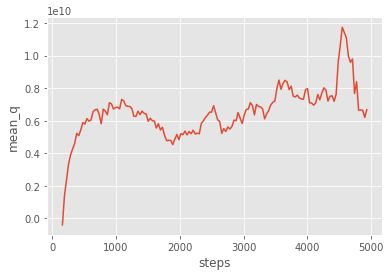

starting train 2
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 13s 13ms/step - reward: 34.3529 - cumulative_reward: -618.0418
train 2 completed. took 42.398 seconds, total_reward: -343.5999999999252 total_profit: 0.6740869069160486
min reward: -89.30000000000105, max reward: 168.70000000000164, mean_reward: -0.06942816730651145


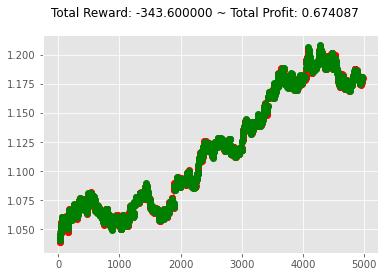

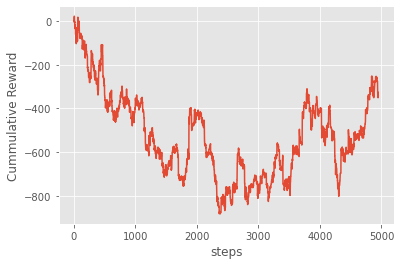

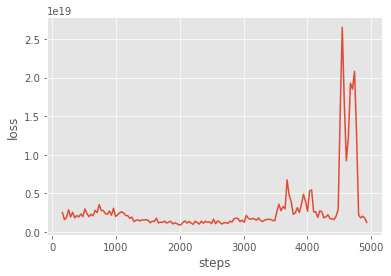

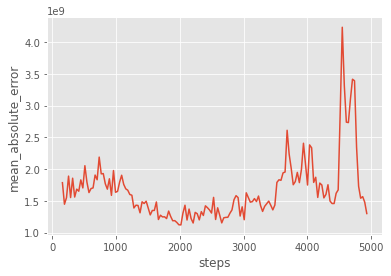

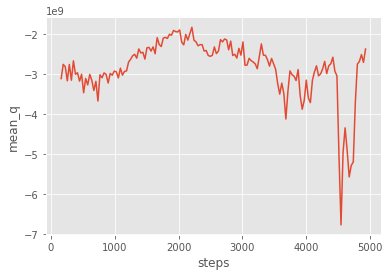

starting train 3
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 16s 16ms/step - reward: 9.2022 - cumulative_reward: -303.4200
train 3 completed. took 68.774 seconds, total_reward: -888.5999999999095 total_profit: 0.6654293871584526
min reward: -190.20000000000036, max reward: 102.99999999999976, mean_reward: -0.17955142453018985


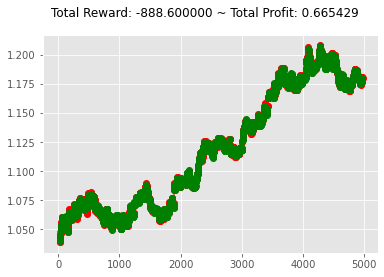

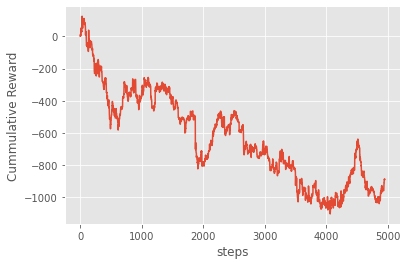

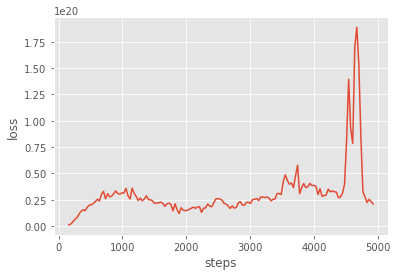

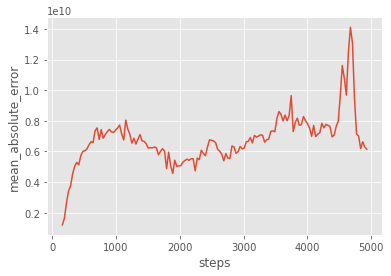

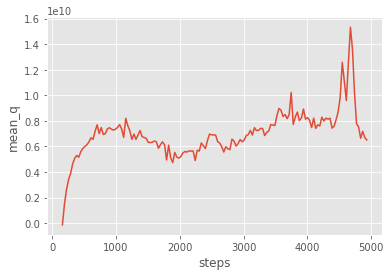

starting train 4
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 15s 16ms/step - reward: 14.9590 - cumulative_reward: 1228.5724
train 4 completed. took 95.559 seconds, total_reward: 1741.1000000000456 total_profit: 0.7737769723688273
min reward: -128.59999999999872, max reward: 154.6000000000003, mean_reward: 0.35180844615074675


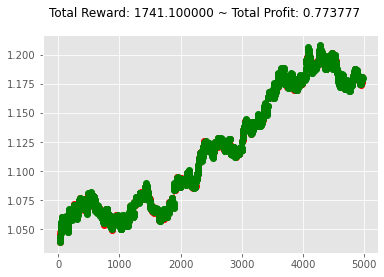

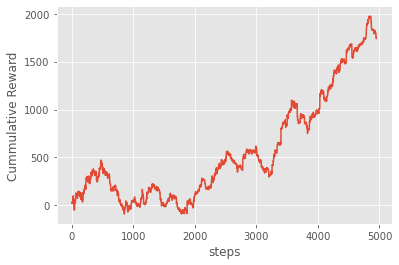

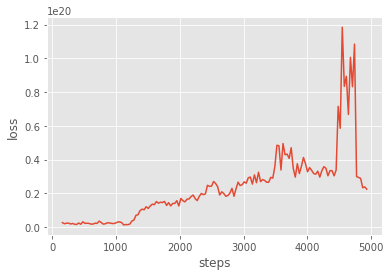

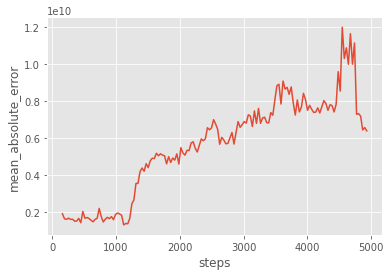

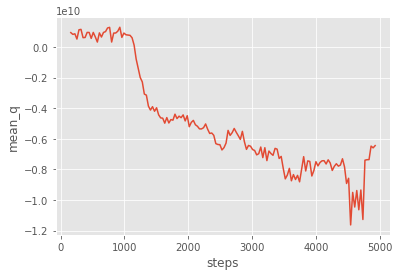

starting train 5
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 16s 17ms/step - reward: 20.3848 - cumulative_reward: -97.4668
train 5 completed. took 123.829 seconds, total_reward: 83.90000000001852 total_profit: 0.7334372910084227
min reward: -114.60000000000025, max reward: 154.50000000000185, mean_reward: 0.016952919781777837


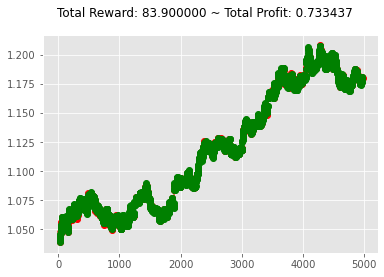

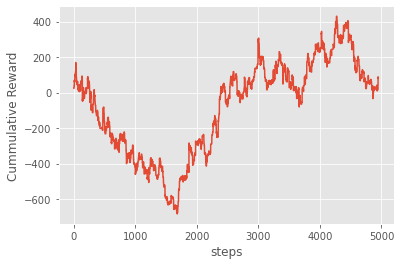

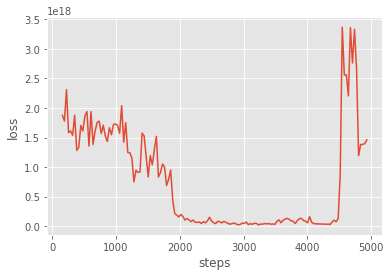

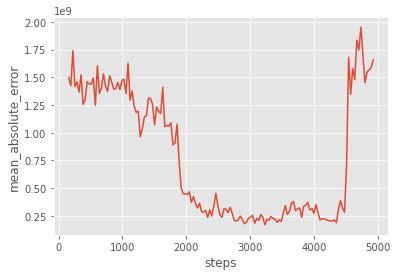

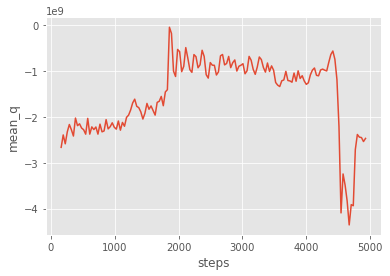

starting train 6
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 17s 17ms/step - reward: 49.3351 - cumulative_reward: -32.4674
train 6 completed. took 153.661 seconds, total_reward: 529.6000000001533 total_profit: 0.7046475576533852
min reward: -118.30000000000007, max reward: 170.40000000000165, mean_reward: 0.1070115174783094


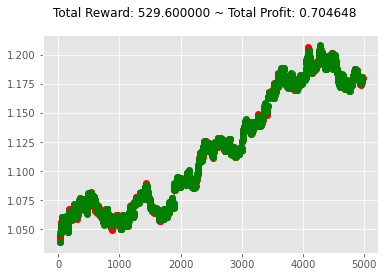

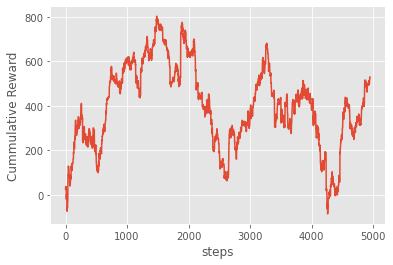

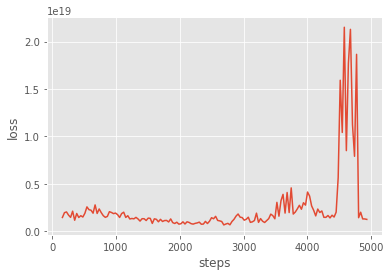

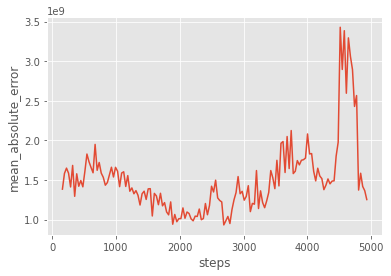

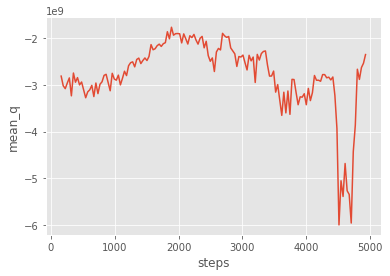

starting train 7
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 18s 19ms/step - reward: 10.7062 - cumulative_reward: -802.0947
train 7 completed. took 185.324 seconds, total_reward: -2369.4000000000706 total_profit: 0.608331815787543
min reward: -151.30000000000086, max reward: 95.19999999999973, mean_reward: -0.4787633865427502


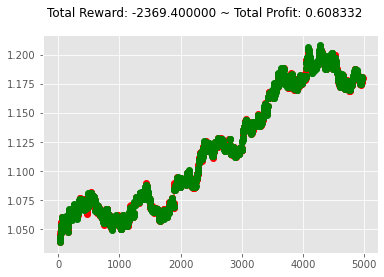

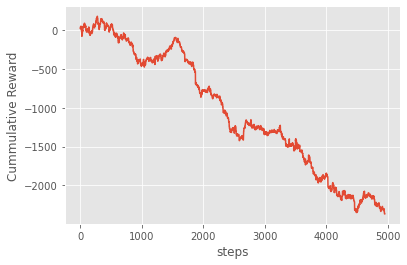

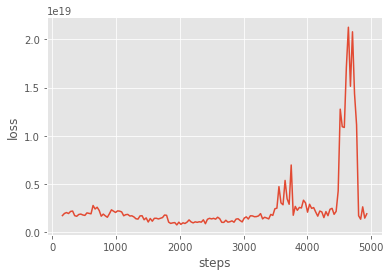

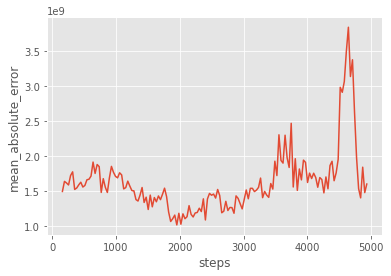

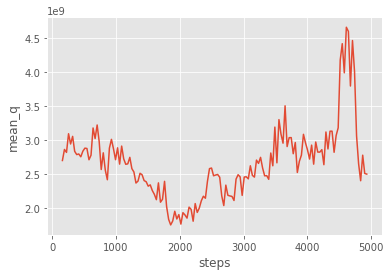

starting train 8
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 19s 20ms/step - reward: 36.8947 - cumulative_reward: 915.6498: 21s - reward: 80.32
train 8 completed. took 220.717 seconds, total_reward: 1479.5000000000484 total_profit: 0.7636596165474159
min reward: -84.59999999999911, max reward: 122.70000000000225, mean_reward: 0.29894928268338017


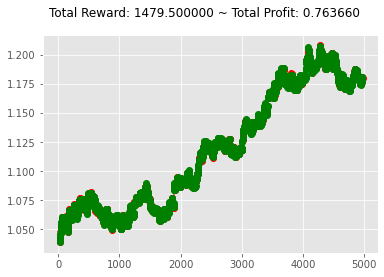

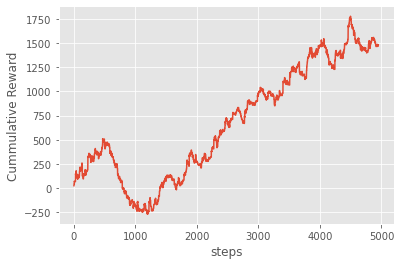

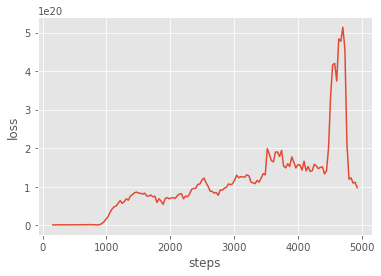

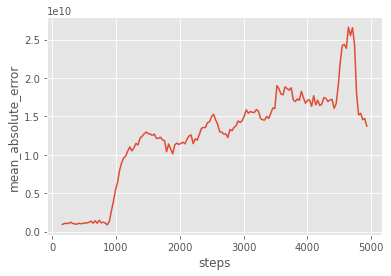

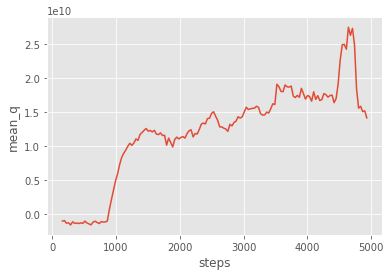

starting train 9
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 20s 21ms/step - reward: -1.2416 - cumulative_reward: -950.2497
train 9 completed. took 256.756 seconds, total_reward: -1228.9000000001479 total_profit: 0.6727342177945399
min reward: -168.70000000000164, max reward: 123.30000000000175, mean_reward: -0.24831279046274962


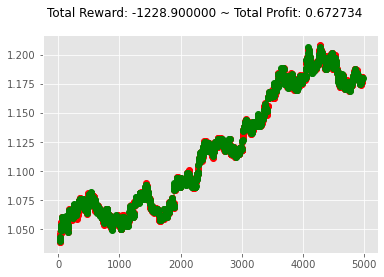

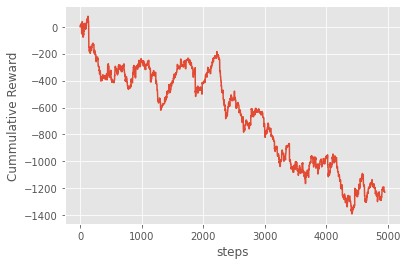

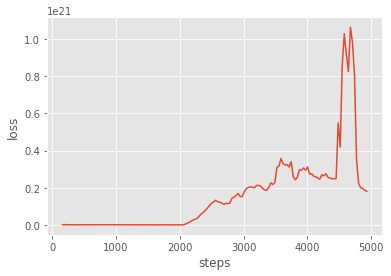

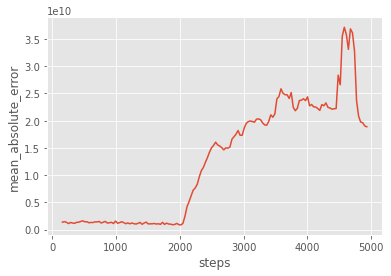

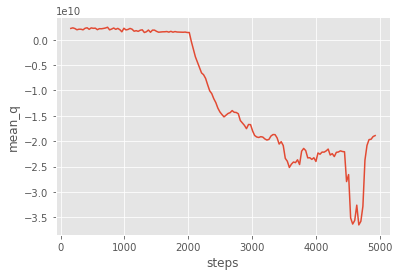

starting train 10
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 18s 18ms/step - reward: 15.4889 - cumulative_reward: -308.5841
train 10 completed. took 292.946 seconds, total_reward: 384.8999999999317 total_profit: 0.7181714906856131
min reward: -92.0999999999994, max reward: 168.70000000000164, mean_reward: 0.07777328753282112


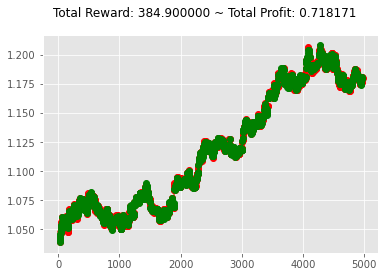

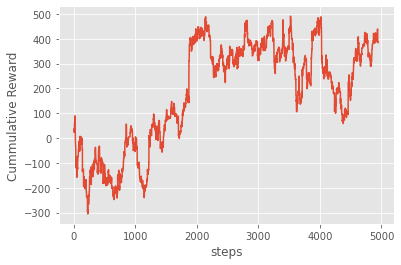

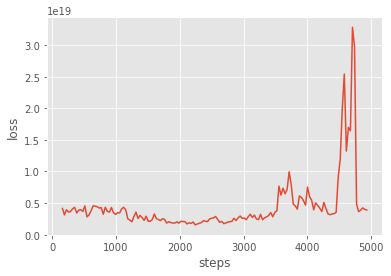

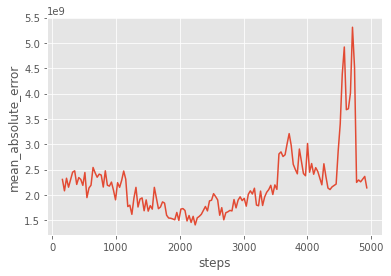

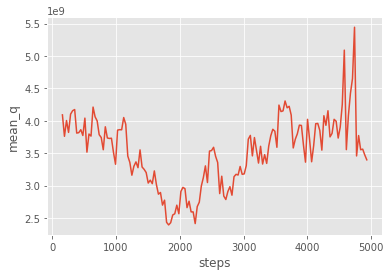

In [7]:
e = Evaluator(agent_creator, env_creator, name="ddpg-fullfeature")
e.train(repeat=10)

average of total_reward across trainings: [-160.52]


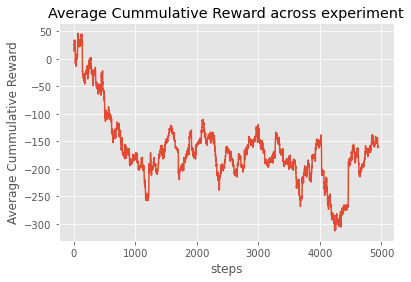

Testing for 1 episodes ...
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
185/199 [==========================>...] - ETA: 0s - reward: -49.5967 - cumulative_reward: 65.2761Episode 1: reward: 280.200, steps: 999
test completed. total_reward: 280.2000000000347 total_profit: 0.962247725693236
min reward: -80.99999999999996, max reward: 62.499999999998664, mean_reward: 0.2804804804805152


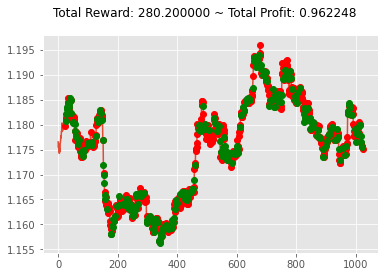

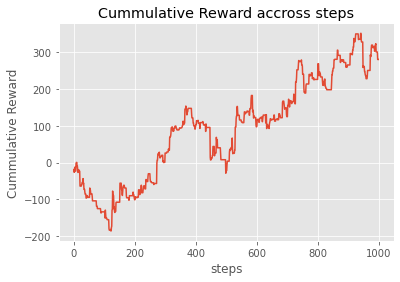

In [8]:
e.process_train_result()
e.test(ForexV0FullFeature(df=FOREX_EURUSD_1H_ASK, frame_bound=(5000, 6000), window_size=window_size))

### Kaggle Dataset 

In [9]:
from data import EURUSD_HOUR
from custom_env import ExternalDataFullFeature

window_size=24
def env_creator():
    return ExternalDataFullFeature(df=EURUSD_HOUR, window_size=window_size, frame_bound=(50, 80000))


env = env_creator()
env_shape = env.reset().shape
print("max possible profit: {}".format(env.max_possible_profit()))
def critic_actor():
    observation_input = Input(shape=(1,) + env_shape, name='observation_input')
    obs = Permute((2, 3, 1), input_shape=(1,) + env_shape)(observation_input)
    obs = Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same')(obs)
    obs = BatchNormalization()(obs)
    obs = Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same')(obs)
    obs = BatchNormalization()(obs)
    obs = Flatten()(obs)

    obs_1 = Dense(256, activation='relu')(obs)
    obs_1 = Dropout(0.2)(obs_1)
    obs_1 = Dense(64, activation='relu')(obs_1)
    obs_out = Dense(nb_actions, activation='softmax')(obs_1)
    actor = Model(inputs=[observation_input], outputs=obs_out)
    # print(actor.summary())

    obs_2 = Permute((2, 3, 1), input_shape=(1,) + env_shape)(observation_input)
    obs_2 = Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same')(obs_2)
    obs_2 = BatchNormalization()(obs_2)
    obs_2 = Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same')(obs_2)
    obs_2 = BatchNormalization()(obs_2)
    obs_2 = Flatten()(obs_2)

    action_input = Input(shape=(nb_actions,), name='action_input')
    a1 = Dense(32, activation='linear')(action_input)

    x = Concatenate()([a1, obs])
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(1)(x)
    x = Activation('linear')(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    # print(critic.summary())
    return actor, critic, action_input

def agent_creator():
    actor, critic, action_input = critic_actor()
    memory = SequentialMemory(limit=256, window_length=1)
    processor = DDPGProcessor()
    random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=0.05, mu=0.02, sigma=0.03)
    agent = DDPGAgent(nb_actions=2, actor=actor, critic=critic, critic_action_input=action_input,
                      memory=memory, nb_steps_warmup_critic=128, nb_steps_warmup_actor=128, batch_size=64, train_interval=32,
                      random_process=random_process,processor=processor, gamma=.5, target_model_update=0.001)
    agent.compile(Adam(lr=.001, clipnorm=1.), metrics=['mae'])
    return agent


max possible profit: 2485856055592.9863


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
starting train 1
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 2869s 179ms/step - reward: 0.2693 - cumulative_reward: 3722.4577
train 1 completed. took 2889.572 seconds, total_reward: 4306.5999999997775 total_profit: 0.02579795587169585
min reward: -459.0000000000005, max reward: 554.0000000000011, mean_reward: 0.05386684011056771


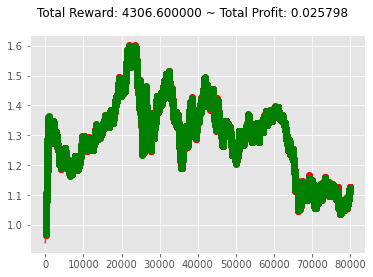

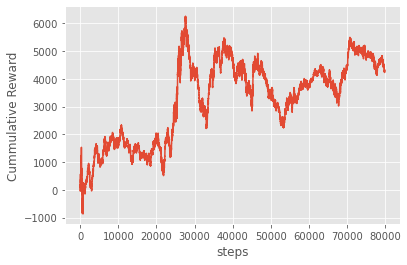

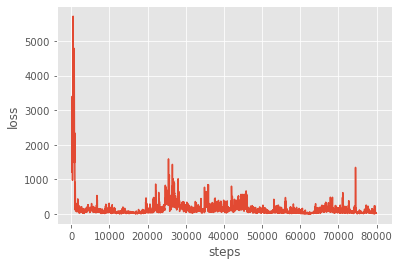

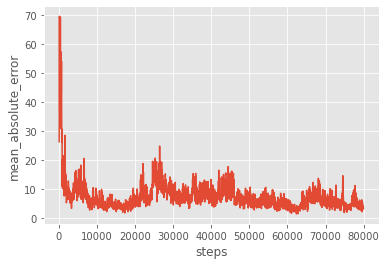

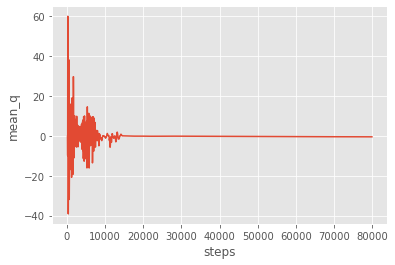

starting train 2
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 2880s 180ms/step - reward: -47.2520 - cumulative_reward: -18.5812
train 2 completed. took 5796.609 seconds, total_reward: 768.3000000000077 total_profit: 0.024225581500898503
min reward: -353.30000000000086, max reward: 365.5999999999993, mean_reward: 0.009609876296138884


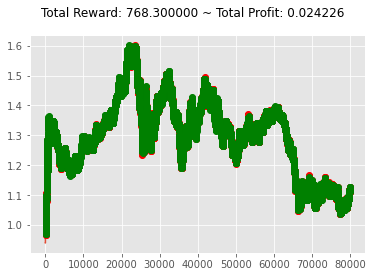

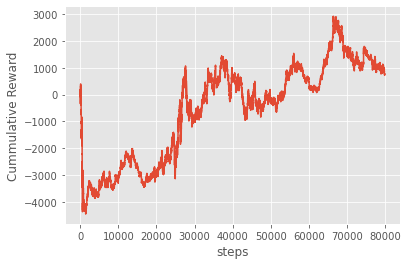

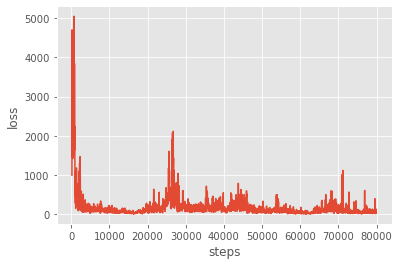

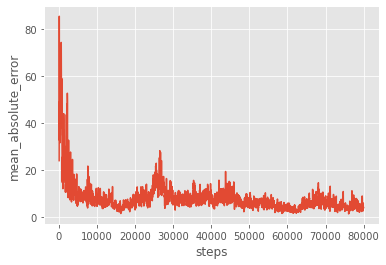

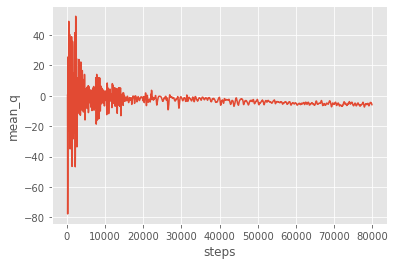

starting train 3
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 2939s 184ms/step - reward: -4.3220 - cumulative_reward: -1407.1977
train 3 completed. took 8763.312 seconds, total_reward: -1951.5000000004284 total_profit: 0.022468417807513862
min reward: -426.3999999999979, max reward: 412.9999999999989, mean_reward: -0.02440931093572688


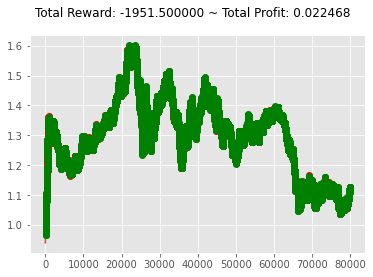

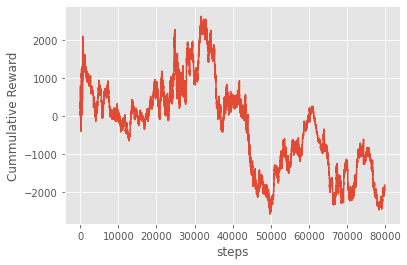

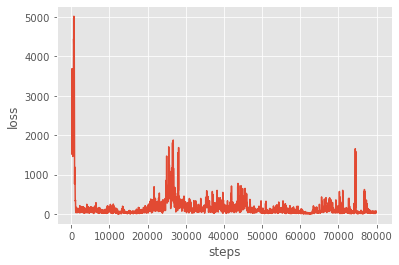

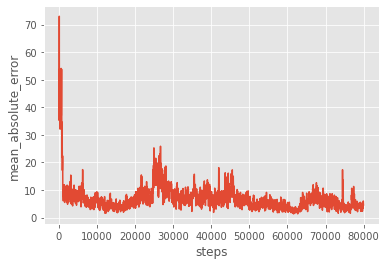

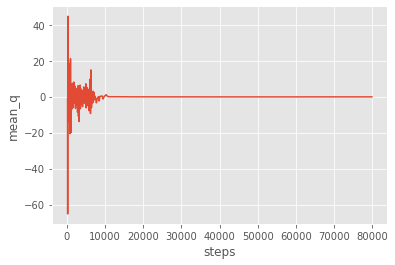

starting train 4
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 2981s 186ms/step - reward: 8.4506 - cumulative_reward: 6526.9497
train 4 completed. took 11777.663 seconds, total_reward: 12001.59999999992 total_profit: 0.035356930953007036
min reward: -340.0000000000003, max reward: 480.00000000000045, mean_reward: 0.1501156987579572


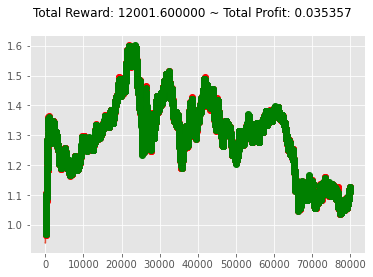

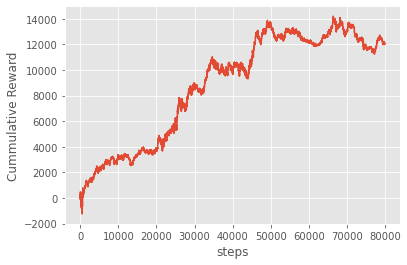

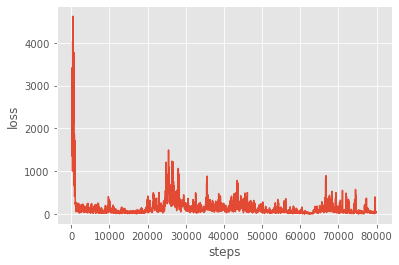

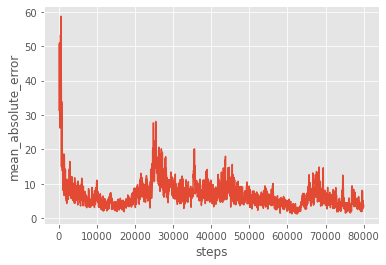

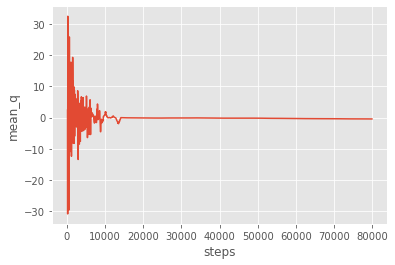

starting train 5
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
13734/15989 [========================>.....] - ETA: 3:14 - reward: -0.1062 - cumulative_reward: -1973.5625

In [ ]:
e = Evaluator(agent_creator, env_creator, name="ddpg-90k")
e.train(repeat=10)

In [ ]:
e.process_train_result()
e.test(ExternalDataFullFeature(df=EURUSD_HOUR, window_size=window_size, frame_bound=(80000, 90000)))